In [165]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader 
import os
import numpy as np
from tqdm import tqdm
from PIL import Image

In [166]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

### Using Cross-entropy Label Smooth as the loss function as it works well than cross-entropy traditionally.

In [167]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import math

class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """
    def __init__(self, num_classes, epsilon=0.1, device='cpu'):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.device = device
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        # targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data, 1)# for mldg da
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)#for zzd
        targets = targets.to(self.device)
        targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (-Variable(targets) * log_probs).mean(0).sum()
        return loss

### Own implemented dataset importer.

In [168]:
class FoodDataset(Dataset):
    def __init__(self, file, transform=None, mode='train'):
        self.transforms = transform
        self.mode = mode
        with open(file, 'r') as f:
            self.image_list = f.readlines()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        label = None
        if self.mode == 'train':
            image, label = self.image_list[index].split('\n')[0].split('\t')
            label = int(label)
        else:
            image = self.image_list[index].split('\n')[0]
        image = Image.open(image).convert('RGB')
        image = self.transforms(image)
        if self.mode == 'train':
            return image, label
        else:
            return image

# Augmentation
Augmentations like random flip, random crop is necessary as it brings much improvement to the model.

In [169]:
transforms_train = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.Pad(10, 10),
                transforms.RandomRotation(45),
                transforms.RandomCrop((224, 224)),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

transforms_test = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

### Function for accuracy validation

In [170]:
def evaluate(prediction, ground_truth):
    num_correct = (np.array(prediction) == np.array(ground_truth)).sum()
    return num_correct / len(prediction)

In [171]:
train_ds = FoodDataset('/media/ntu/volume2/home/s121md302_07/food/data/train.txt', transform=transforms_train)
val_ds = FoodDataset('/media/ntu/volume2/home/s121md302_07/food/data/val.txt', transform=transforms_test)
test_ds = FoodDataset('/media/ntu/volume2/home/s121md302_07/food/data/test.txt', transform=transforms_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=8)

## Hyperparameters
Using ResNet34 with Adam optimizer and StrpLR scheduler in this experiment.
The learning rate is set initially to 0.0001 and decay by 10 times every 20 epochs.

In [172]:
num_classes = 5
train_model = models.resnet34(pretrained=True)
train_model.fc = nn.Linear(512, num_classes)

model_str = 'resnet34'
output_dir = 'checkpoint_' + model_str
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(train_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

## Training with model freezed
Freezing the model will help the model to converge faster in the future.

In [173]:
for param in train_model.parameters():
    param.requires_grad = False
for param in train_model.fc.parameters():
    param.requires_grad = True
for i in range(5):
    train_model.train()
    train_model.to(device)
    for img, label in tqdm(train_dl):
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output= train_model(img) 
        loss = ce_loss(output, label) 
        loss.backward()
        optimizer.step()


100%|██████████| 16/16 [00:01<00:00, 14.51it/s]


# Training
Training for 100 epochs. Validation and checkpoint at every 10 epochs.

In [174]:
for param in train_model.parameters():
    param.requires_grad = True
epoch = 100
highest_acc = {'epoch': 0, 'accuracy': 0}
loss_list = []
for ep in range(epoch):
    train_model.train()
    train_model.to(device)
    count = 0
    running_loss = 0.0
    validation_loss = 0.0
    output_list = []
    ground_truth_list = []
    for img, label in tqdm(train_dl):
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output= train_model(img)
        loss = ce_loss(output, label)
        count += 1
        prediction = torch.argmax(output, dim=1)
        output_list.extend(prediction.detach().cpu())
        ground_truth_list.extend(label.cpu())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_list.append(running_loss/count)
    
    scheduler.step()
        
    accuracy = evaluate(output_list, ground_truth_list)
    print(f'Epoch[{ep}] training accuracy: {accuracy} '
            f'training loss: {running_loss / count:.3e} Base Lr: {optimizer.param_groups[0]["lr"]:.5e}')

    if ep % 10 == 0:
        train_model.eval()
        count = 0
        output_list = []
        ground_truth_list = []
        for img, label in tqdm(val_dl):
            with torch.no_grad():
                img = img.to(device)
                lbl = label.to(device)

                output= train_model(img)

                val_loss = ce_loss(output, lbl)

                validation_loss += val_loss.item()
                count += 1
                prediction = torch.argmax(output, dim=1)
                output_list.extend(prediction.detach().cpu())
                ground_truth_list.extend(label)
        accuracy = evaluate(output_list, ground_truth_list)
        if accuracy > highest_acc['accuracy']:
            highest_acc['accuracy'] = accuracy
            highest_acc['epoch'] = ep
        print(f'Accuracy: {accuracy}    Epoch:{ep}')

100%|██████████| 16/16 [00:01<00:00,  9.03it/s]


Epoch[0] training accuracy: 0.582 training loss: 1.102e+00 Base Lr: 1.00000e-04


100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Accuracy: 0.78    Epoch:0


100%|██████████| 16/16 [00:01<00:00,  8.40it/s]


Epoch[1] training accuracy: 0.83 training loss: 4.956e-01 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.56it/s]


Epoch[2] training accuracy: 0.894 training loss: 3.296e-01 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.29it/s]


Epoch[3] training accuracy: 0.918 training loss: 2.518e-01 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.51it/s]


Epoch[4] training accuracy: 0.936 training loss: 1.949e-01 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.60it/s]


Epoch[5] training accuracy: 0.95 training loss: 1.663e-01 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.07it/s]


Epoch[6] training accuracy: 0.96 training loss: 1.301e-01 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.17it/s]


Epoch[7] training accuracy: 0.97 training loss: 9.165e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.53it/s]


Epoch[8] training accuracy: 0.974 training loss: 8.313e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  8.81it/s]


Epoch[9] training accuracy: 0.97 training loss: 9.327e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.26it/s]


Epoch[10] training accuracy: 0.976 training loss: 7.988e-02 Base Lr: 1.00000e-04


100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


Accuracy: 0.8533333333333334    Epoch:10


100%|██████████| 16/16 [00:01<00:00,  9.49it/s]


Epoch[11] training accuracy: 0.98 training loss: 6.553e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.21it/s]


Epoch[12] training accuracy: 0.984 training loss: 6.940e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.37it/s]


Epoch[13] training accuracy: 0.972 training loss: 8.136e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.14it/s]


Epoch[14] training accuracy: 0.99 training loss: 6.888e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.49it/s]


Epoch[15] training accuracy: 0.982 training loss: 5.235e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


Epoch[16] training accuracy: 0.982 training loss: 7.299e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.21it/s]


Epoch[17] training accuracy: 0.988 training loss: 6.729e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  8.98it/s]


Epoch[18] training accuracy: 0.962 training loss: 9.369e-02 Base Lr: 1.00000e-04


100%|██████████| 16/16 [00:01<00:00,  9.35it/s]


Epoch[19] training accuracy: 0.95 training loss: 1.324e-01 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.05it/s]


Epoch[20] training accuracy: 0.972 training loss: 7.719e-02 Base Lr: 1.00000e-05


100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Accuracy: 0.8533333333333334    Epoch:20


100%|██████████| 16/16 [00:01<00:00,  9.64it/s]


Epoch[21] training accuracy: 0.988 training loss: 5.635e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.57it/s]


Epoch[22] training accuracy: 0.988 training loss: 5.091e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.15it/s]


Epoch[23] training accuracy: 0.984 training loss: 4.448e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.20it/s]


Epoch[24] training accuracy: 0.986 training loss: 5.070e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  8.98it/s]


Epoch[25] training accuracy: 0.986 training loss: 4.628e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


Epoch[26] training accuracy: 0.984 training loss: 3.957e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  8.94it/s]


Epoch[27] training accuracy: 0.994 training loss: 2.104e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.30it/s]


Epoch[28] training accuracy: 0.996 training loss: 2.665e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.33it/s]


Epoch[29] training accuracy: 0.996 training loss: 2.086e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  8.83it/s]


Epoch[30] training accuracy: 0.996 training loss: 2.513e-02 Base Lr: 1.00000e-05


100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Accuracy: 0.8866666666666667    Epoch:30


100%|██████████| 16/16 [00:01<00:00,  9.24it/s]


Epoch[31] training accuracy: 0.996 training loss: 2.453e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.02it/s]


Epoch[32] training accuracy: 0.998 training loss: 1.604e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  8.92it/s]


Epoch[33] training accuracy: 0.996 training loss: 1.822e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  8.96it/s]


Epoch[34] training accuracy: 0.996 training loss: 1.826e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.43it/s]


Epoch[35] training accuracy: 0.996 training loss: 1.651e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.34it/s]


Epoch[36] training accuracy: 0.998 training loss: 2.443e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.37it/s]


Epoch[37] training accuracy: 0.992 training loss: 3.162e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  8.80it/s]


Epoch[38] training accuracy: 0.994 training loss: 2.475e-02 Base Lr: 1.00000e-05


100%|██████████| 16/16 [00:01<00:00,  9.16it/s]


Epoch[39] training accuracy: 0.994 training loss: 2.059e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.50it/s]


Epoch[40] training accuracy: 0.998 training loss: 1.303e-02 Base Lr: 1.00000e-06


100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Accuracy: 0.9    Epoch:40


100%|██████████| 16/16 [00:01<00:00,  9.17it/s]


Epoch[41] training accuracy: 0.998 training loss: 1.749e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.09it/s]


Epoch[42] training accuracy: 0.998 training loss: 1.081e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  8.99it/s]


Epoch[43] training accuracy: 1.0 training loss: 1.036e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.15it/s]


Epoch[44] training accuracy: 0.998 training loss: 1.088e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  8.70it/s]


Epoch[45] training accuracy: 0.996 training loss: 2.030e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.24it/s]


Epoch[46] training accuracy: 0.99 training loss: 2.954e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.17it/s]


Epoch[47] training accuracy: 0.998 training loss: 1.593e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.16it/s]


Epoch[48] training accuracy: 0.994 training loss: 2.014e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.02it/s]


Epoch[49] training accuracy: 0.996 training loss: 1.504e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.51it/s]


Epoch[50] training accuracy: 0.996 training loss: 1.835e-02 Base Lr: 1.00000e-06


100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


Accuracy: 0.8933333333333333    Epoch:50


100%|██████████| 16/16 [00:01<00:00,  8.63it/s]


Epoch[51] training accuracy: 0.996 training loss: 2.184e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.40it/s]


Epoch[52] training accuracy: 1.0 training loss: 6.978e-03 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.73it/s]


Epoch[53] training accuracy: 0.994 training loss: 1.453e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.68it/s]


Epoch[54] training accuracy: 0.996 training loss: 1.737e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  8.98it/s]


Epoch[55] training accuracy: 0.998 training loss: 2.077e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.40it/s]


Epoch[56] training accuracy: 0.998 training loss: 1.308e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.17it/s]


Epoch[57] training accuracy: 0.996 training loss: 1.761e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  9.32it/s]


Epoch[58] training accuracy: 0.996 training loss: 2.326e-02 Base Lr: 1.00000e-06


100%|██████████| 16/16 [00:01<00:00,  8.84it/s]


Epoch[59] training accuracy: 0.998 training loss: 1.336e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.05it/s]


Epoch[60] training accuracy: 0.996 training loss: 1.555e-02 Base Lr: 1.00000e-07


100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


Accuracy: 0.88    Epoch:60


100%|██████████| 16/16 [00:01<00:00,  8.89it/s]


Epoch[61] training accuracy: 0.998 training loss: 1.783e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.05it/s]


Epoch[62] training accuracy: 0.998 training loss: 2.004e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  8.81it/s]


Epoch[63] training accuracy: 1.0 training loss: 9.744e-03 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.06it/s]


Epoch[64] training accuracy: 1.0 training loss: 1.214e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.11it/s]


Epoch[65] training accuracy: 0.998 training loss: 1.395e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  8.96it/s]


Epoch[66] training accuracy: 0.994 training loss: 2.480e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.22it/s]


Epoch[67] training accuracy: 1.0 training loss: 8.041e-03 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.06it/s]


Epoch[68] training accuracy: 0.994 training loss: 1.658e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  8.81it/s]


Epoch[69] training accuracy: 1.0 training loss: 1.080e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.17it/s]


Epoch[70] training accuracy: 0.996 training loss: 2.328e-02 Base Lr: 1.00000e-07


100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Accuracy: 0.88    Epoch:70


100%|██████████| 16/16 [00:01<00:00,  9.04it/s]


Epoch[71] training accuracy: 0.994 training loss: 2.310e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.13it/s]


Epoch[72] training accuracy: 0.996 training loss: 2.149e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.07it/s]


Epoch[73] training accuracy: 0.99 training loss: 2.403e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.00it/s]


Epoch[74] training accuracy: 0.998 training loss: 1.236e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.19it/s]


Epoch[75] training accuracy: 0.996 training loss: 1.536e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.34it/s]


Epoch[76] training accuracy: 0.996 training loss: 1.790e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  8.93it/s]


Epoch[77] training accuracy: 0.992 training loss: 2.800e-02 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  8.94it/s]


Epoch[78] training accuracy: 0.998 training loss: 9.971e-03 Base Lr: 1.00000e-07


100%|██████████| 16/16 [00:01<00:00,  9.33it/s]


Epoch[79] training accuracy: 1.0 training loss: 9.576e-03 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.10it/s]


Epoch[80] training accuracy: 0.988 training loss: 4.023e-02 Base Lr: 1.00000e-08


100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


Accuracy: 0.8933333333333333    Epoch:80


100%|██████████| 16/16 [00:01<00:00,  8.87it/s]


Epoch[81] training accuracy: 0.992 training loss: 2.543e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.73it/s]


Epoch[82] training accuracy: 0.99 training loss: 2.966e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.11it/s]


Epoch[83] training accuracy: 0.992 training loss: 2.295e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.42it/s]


Epoch[84] training accuracy: 1.0 training loss: 1.201e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  8.37it/s]


Epoch[85] training accuracy: 0.998 training loss: 2.015e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.15it/s]


Epoch[86] training accuracy: 1.0 training loss: 1.720e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.12it/s]


Epoch[87] training accuracy: 0.994 training loss: 1.641e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.25it/s]


Epoch[88] training accuracy: 0.996 training loss: 1.198e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.01it/s]


Epoch[89] training accuracy: 0.996 training loss: 1.504e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.25it/s]


Epoch[90] training accuracy: 1.0 training loss: 1.170e-02 Base Lr: 1.00000e-08


100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Accuracy: 0.8866666666666667    Epoch:90


100%|██████████| 16/16 [00:01<00:00,  9.05it/s]


Epoch[91] training accuracy: 0.996 training loss: 2.449e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  8.86it/s]


Epoch[92] training accuracy: 0.998 training loss: 1.701e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  8.79it/s]


Epoch[93] training accuracy: 0.998 training loss: 1.913e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  8.97it/s]


Epoch[94] training accuracy: 0.994 training loss: 2.402e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.58it/s]


Epoch[95] training accuracy: 0.996 training loss: 1.596e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.08it/s]


Epoch[96] training accuracy: 0.998 training loss: 1.317e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.18it/s]


Epoch[97] training accuracy: 0.994 training loss: 1.594e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  9.03it/s]


Epoch[98] training accuracy: 1.0 training loss: 1.074e-02 Base Lr: 1.00000e-08


100%|██████████| 16/16 [00:01<00:00,  8.81it/s]

Epoch[99] training accuracy: 0.996 training loss: 2.302e-02 Base Lr: 1.00000e-09


### Show the highest accuracy and save the final weight of the model.

highest_acc: 0.9  epoch: 40


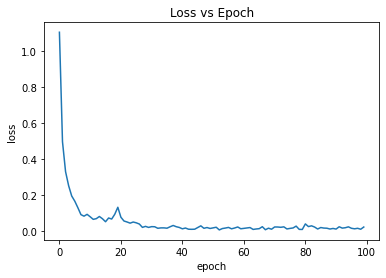

In [175]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(loss_list))], loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
print('highest_acc: {}  epoch: {}'.format(highest_acc['accuracy'], highest_acc['epoch']))